In [1]:
import numpy as np
import matplotlib.pyplot as plt
from graphstats import *
from scipy.stats import mannwhitneyu as mwu

In [3]:
# List of number of nodes
n = [150, 200, 250, 300, 350, 400, 450, 500]

# Number of Monte Carlo simulations
it = 100

# The number of seeds = int(n*seed_ratio)
seed_ratio = 0.1

# Class 1 prior
pi1 = 0.5

# Class 2 prior
pi2 = 1 - pi1
pis = np.array([pi1, pi2])
pi = pis

# Setting up B matrix
p = 0.52
q = 0.48

B = np.array([[p**2, p*q], [p*q, q**2]])

# Hard coding the maximum embedding dimension
max_dim = 1

# Setting the edge weight distribution parameters
mu1 = 100
mu2 = 102
scale1 = 9
scale2 = 9
means = np.array([[mu1, mu2], [mu2, mu1]])
scales = np.array([[scale1, scale2], [scale2, scale1]])

# Initalizing lists to store misclassification results
# Naming convention "a_b_c"
# a = The type of classification procedure (ptr = pass-to-ranks, up = updated priors)
# b = The  (test = testing for a difference in the means)
# c = The edge weight distribution setting (it is always "mean_type""std_type")
#     d = different, s = same; ds = different mean same scale; ss = same mean same scale
ptr_test_ds = [[] for i in range(len(n))]
up_test_ds = [[] for i in range(len(n))]

# Loop over the number of nodes
for i in tqdm(range(len(n))):
    # ni = The number of training data for block i
    n1 = int(np.round(n[i]*seed_ratio*pi[0]))
    n2 = int(np.round(n[i]*seed_ratio*(1 - pi[0])))
    
    # Find the total number of training data
    ns  = n1 + n2

    # Array of indices corresponding to training data
    seeds1 = np.arange(0, n1)
    seeds2 = np.arange(int(np.round(n[i]*pi[0])), int(np.round(n[i]*pi[0])) + n2)
    all_seeds = np.concatenate((seeds1, seeds2))

    # Labels for the training data
    labels1 = np.zeros(len(seeds1))
    labels2 = np.ones(len(seeds2))
    seed_labels = np.concatenate((labels1, labels2))
    
    # Ground truth
    all_labels = np.concatenate((np.zeros(int(np.round(n[i]*pi[0]))), np.ones(int(np.round(n[i]*pi[1])))))
    
    # Loop over the number of Monte Carlo iterations
    for j in range(it):
        # Generate an adjacency matrix with n[i] nodes
        # class priors = pis
        # block adjacency probabilities given by B
        # weighted = True
        # weight distribution = normal/gaussian with means = means and scales = scales
        A = adj_matrix(n[i], pis, B, True, dist = "normal", means = means, scales = scales, acorn = i*j + j + i)
        
        # Pass-to-ranks classification
        A_ptr = pass_to_ranks(A)
        V_ptr, U_ptr = adj_spectral_embedding(A_ptr, max_dim = 2, acorn = j)
        X_hat = V_ptr[:, :1] 
        ptr_class = gaussian_classification(X_hat, all_seeds, seed_labels)
        
        # Updated priors classification
        C = strip_weights(A)
        V_C, U_C = adj_spectral_embedding(C, max_dim = 2, acorn = j)
        X_hat_C = V_C[:, :1]
        up_class = updated_priors_classification(A, all_seeds, seed_labels, pis, max_dim = 1, add_smoothing = 1, test = True, X_hat = X_hat_C, acorn = j)
        
        # Missclassifcation rates for unlabeled nodes
        ptr_test_ds[i].append((np.sum(ptr_class == all_labels) - ns)/(n[i] - ns))
        up_test_ds[i].append((np.sum(up_class == all_labels) - ns)/(n[i] - ns))

100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [1:42:22<00:00, 767.87s/it]


In [4]:
import _pickle as pickle
pickle.dump(ptr_test_ds, open('ptr_ds_DAS.pkl', 'wb'))
pickle.dump(up_test_ds, open('up_ds_DAS.pkl', 'wb'))
#up_test_ds = pickle.load(open('up_ds_DAS.pkl', 'rb'))
#ptr_test_ds = pickle.load(open('ptr_ds_DAS.pkl', 'rb'))

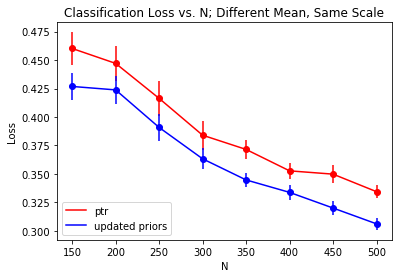

In [5]:
ptr_ds_means = np.array([np.mean(i) for i in ptr_test_ds])
up_ds_means = np.array([np.mean(i) for i in up_test_ds])

ptr_ds_std = np.array([np.std(i, ddof = 1) for i in ptr_test_ds])
up_ds_std = np.array([np.std(i, ddof = 1) for i in up_test_ds])

fig, ax = plt.subplots(1,1)

ax.plot(n, 1 - ptr_ds_means, label = 'ptr', c = 'r')
ax.plot(n, 1 - up_ds_means, label = 'updated priors', c = 'b')
ax.errorbar(n, 1 - ptr_ds_means, yerr = 1.96*ptr_ds_std/np.sqrt(it), fmt='o', c = 'r')
ax.errorbar(n, 1 - up_ds_means, yerr = 1.96*up_ds_std/np.sqrt(it), fmt='o', c = 'b')
ax.set_title('Classification Loss vs. N; Different Mean, Same Scale')
ax.set_xlabel('N')
ax.set_ylabel('Loss')
ax.legend(loc = 'lower left')

plt.savefig('ds_DAS.png')

In [6]:
n = [150, 200, 250, 300, 350, 400, 450, 500]
it = 100
seed_ratio = 0.1
pi1 = 0.5
pi2 = 1 - pi1
pis = np.array([pi1, pi2])
pi = pis

p = 0.52
q = 0.48

B = np.array([[p**2, p*q], [p*q, q**2]])

max_dim = 1

mu1 = 100
mu2 = 102
scale1 = 4
scale2 = 9

means = np.array([[mu1, mu2], [mu2, mu1]])
scales = np.array([[scale1, scale2], [scale2, scale1]])

ptr_test_dd = [[] for i in range(len(n))]
up_test_dd = [[] for i in range(len(n))]

for i in tqdm(range(len(n))):
    n1 = int(np.round(n[i]*seed_ratio*pi[0]))
    n2 = int(np.round(n[i]*seed_ratio*(1 - pi[0])))
    
    ns  = n1 + n2

    seeds1 = np.arange(0, n1)
    seeds2 = np.arange(int(np.round(n[i]*pi[0])), int(np.round(n[i]*pi[0])) + n2)
    all_seeds = np.concatenate((seeds1, seeds2))

    labels1 = np.zeros(len(seeds1))
    labels2 = np.ones(len(seeds2))
    seed_labels = np.concatenate((labels1, labels2))

    all_labels = np.concatenate((np.zeros(int(np.round(n[i]*pi[0]))), np.ones(int(np.round(n[i]*pi[1])))))
    
    for j in range(it):
        A = adj_matrix(n[i], pis, B, True, dist = "normal", means = means, scales = scales, acorn = j)
        
        A_ptr = pass_to_ranks(A)
        V_ptr, U_ptr = adj_spectral_embedding(A_ptr, max_dim = 2, acorn = j)
        X_hat = V_ptr[:, :1] 
        ptr_class = gaussian_classification(X_hat, all_seeds, seed_labels)
        
        C = strip_weights(A)
        V_C, U_C = adj_spectral_embedding(C, max_dim = 2, acorn = j)
        X_hat_C = V_C[:, :1] 
        
        up_class = updated_priors_classification(A, all_seeds, seed_labels, pis, max_dim = 1, add_smoothing = 1, test = True, X_hat = X_hat_C, acorn = j)
        
        ptr_test_dd[i].append((np.sum(ptr_class == all_labels) - ns)/(n[i] - ns))
        up_test_dd[i].append((np.sum(up_class == all_labels) - ns)/(n[i] - ns))

100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [1:01:58<00:00, 464.76s/it]


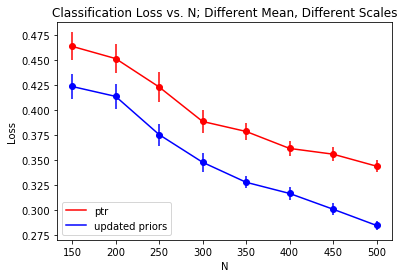

In [7]:
ptr_dd_means = np.array([np.mean(i) for i in ptr_test_dd])
up_dd_means = np.array([np.mean(i) for i in up_test_dd])

ptr_dd_std = np.array([np.std(i, ddof = 1) for i in ptr_test_dd])
up_dd_std = np.array([np.std(i, ddof = 1) for i in up_test_dd])

fig, ax = plt.subplots(1,1)

ax.plot(n, 1 - ptr_dd_means, label = 'ptr', c = 'r')
ax.plot(n, 1 - up_dd_means, label = 'updated priors', c = 'b')
ax.errorbar(n, 1 - ptr_dd_means, yerr = 1.96*ptr_dd_std/np.sqrt(it), fmt='o', c = 'r')
ax.errorbar(n, 1 - up_dd_means, yerr = 1.96*up_dd_std/np.sqrt(it), fmt='o', c = 'b')
ax.set_title('Classification Loss vs. N; Different Mean, Different Scales')
ax.set_xlabel('N')
ax.set_ylabel('Loss')
ax.legend(loc = 'lower left')

plt.savefig('dd_DAS.png')

In [8]:
n = [150, 200, 250, 300, 350, 400, 450, 500]
it = 100
seed_ratio = 0.1
pi1 = 0.5
pi2 = 1 - pi1
pis = np.array([pi1, pi2])
pi = pis

p = 0.52
q = 0.48

B = np.array([[p**2, p*q], [p*q, q**2]])

max_dim = 1

mu1 = 100
mu2 = 100
scale1 = 4
scale2 = 9

means = np.array([[mu1, mu2], [mu2, mu1]])
scales = np.array([[scale1, scale2], [scale2, scale1]])

ptr_test_sd = [[] for i in range(len(n))]
up_test_sd = [[] for i in range(len(n))]

for i in tqdm(range(len(n))):
    n1 = int(np.round(n[i]*seed_ratio*pi[0]))
    n2 = int(np.round(n[i]*seed_ratio*(1 - pi[0])))
    
    ns  = n1 + n2

    seeds1 = np.arange(0, n1)
    seeds2 = np.arange(int(np.round(n[i]*pi[0])), int(np.round(n[i]*pi[0])) + n2)
    all_seeds = np.concatenate((seeds1, seeds2))

    labels1 = np.zeros(len(seeds1))
    labels2 = np.ones(len(seeds2))
    seed_labels = np.concatenate((labels1, labels2))

    all_labels = np.concatenate((np.zeros(int(np.round(n[i]*pi[0]))), np.ones(int(np.round(n[i]*pi[1])))))
    
    for j in range(it):
        A = adj_matrix(n[i], pis, B, True, dist = "normal", means = means, scales = scales, acorn = j)
        
        A_ptr = pass_to_ranks(A)
        V_ptr, U_ptr = adj_spectral_embedding(A_ptr, max_dim = 2, acorn = j)
        X_hat = V_ptr[:, :1] 
        #X_hat = X_hat[:, None]
        ptr_class = gaussian_classification(X_hat, all_seeds, seed_labels)
        
        C = strip_weights(A)
        V_C, U_C = adj_spectral_embedding(C, max_dim = 2, acorn = j)
        X_hat_C = V_C[:, :1] 
        #X_hat_C = X_hat_C[:, None]
        
        up_class = updated_priors_classification(A, all_seeds, seed_labels, pis, max_dim = 1, add_smoothing = 1, test = True, X_hat = X_hat_C, acorn = j)
        
        ptr_test_sd[i].append((np.sum(ptr_class == all_labels) - ns)/(n[i] - ns))
        up_test_sd[i].append((np.sum(up_class == all_labels) - ns)/(n[i] - ns))

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [57:21<00:00, 430.13s/it]


In [9]:
import _pickle as pickle
pickle.dump(ptr_test_sd, open('ptr_sd_DAS.pkl', 'wb'))
pickle.dump(up_test_sd, open('up_sd_DAS.pkl', 'wb'))

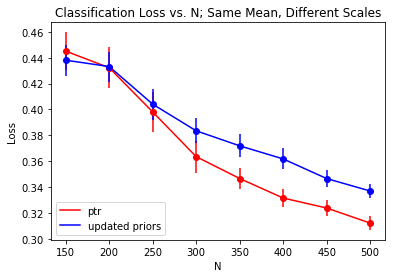

In [10]:
ptr_sd_means = np.array([np.mean(i) for i in ptr_test_sd])
up_sd_means = np.array([np.mean(i) for i in up_test_sd])

ptr_sd_std = np.array([np.std(i, ddof = 1) for i in ptr_test_sd])
up_sd_std = np.array([np.std(i, ddof = 1) for i in up_test_sd])

fig, ax = plt.subplots(1,1)

ax.plot(n, 1 - ptr_sd_means, label = 'ptr', c = 'r')
ax.plot(n, 1 - up_sd_means, label = 'updated priors', c = 'b')
ax.errorbar(n, 1 - ptr_sd_means, yerr = 1.96*ptr_sd_std/np.sqrt(it), fmt='o', c = 'r')
ax.errorbar(n, 1 - up_sd_means, yerr = 1.96*up_sd_std/np.sqrt(it), fmt='o', c = 'b')
ax.set_title('Classification Loss vs. N; Same Mean, Different Scales')
ax.set_xlabel('N')
ax.set_ylabel('Loss')
ax.legend(loc = 'lower left')

plt.savefig('sd_DAS.png')

In [11]:
n = [150, 200, 250, 300, 350, 400, 450, 500]
it = 100
seed_ratio = 0.1
pi1 = 0.5
pi2 = 1 - pi1
pis = np.array([pi1, pi2])
pi = pis

p = 0.52
q = 0.48

B = np.array([[p**2, p*q], [p*q, q**2]])

max_dim = 1

mu1 = 100
mu2 = 100
scale1 = 9
scale2 = 9

means = np.array([[mu1, mu2], [mu2, mu1]])
scales = np.array([[scale1, scale2], [scale2, scale1]])

ptr_test_ss = [[] for i in range(len(n))]
up_test_ss = [[] for i in range(len(n))]

for i in tqdm(range(len(n))):
    n1 = int(np.round(n[i]*seed_ratio*pi[0]))
    n2 = int(np.round(n[i]*seed_ratio*(1 - pi[0])))
    
    ns  = n1 + n2

    seeds1 = np.arange(0, n1)
    seeds2 = np.arange(int(np.round(n[i]*pi[0])), int(np.round(n[i]*pi[0])) + n2)
    all_seeds = np.concatenate((seeds1, seeds2))

    labels1 = np.zeros(len(seeds1))
    labels2 = np.ones(len(seeds2))
    seed_labels = np.concatenate((labels1, labels2))

    all_labels = np.concatenate((np.zeros(int(np.round(n[i]*pi[0]))), np.ones(int(np.round(n[i]*pi[1])))))
    
    for j in range(it):
        A = adj_matrix(n[i], pis, B, True, dist = "normal", means = means, scales = scales, acorn = j)
        
        A_ptr = pass_to_ranks(A)
        V_ptr, U_ptr = adj_spectral_embedding(A_ptr, max_dim = 2, acorn = j)
        X_hat = V_ptr[:, :1] 
        #X_hat = X_hat[:, None]
        ptr_class = gaussian_classification(X_hat, all_seeds, seed_labels)
        
        C = strip_weights(A)
        V_C, U_C = adj_spectral_embedding(C, max_dim = 2, acorn = j)
        X_hat_C = V_C[:, :1]
        
        up_class = updated_priors_classification(A, all_seeds, seed_labels, pis, max_dim = 1, add_smoothing = 1, test = True, X_hat = X_hat_C, acorn = j)
        
        ptr_test_ss[i].append((np.sum(ptr_class == all_labels) - ns)/(n[i] - ns))
        up_test_ss[i].append((np.sum(up_class == all_labels) - ns)/(n[i] - ns))

100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [2:37:28<00:00, 1181.07s/it]


In [12]:
import _pickle as pickle
pickle.dump(ptr_test_ss, open('ptr_ss_DAS.pkl', 'wb'))
pickle.dump(up_test_ss, open('up_ss_DAS.pkl', 'wb'))

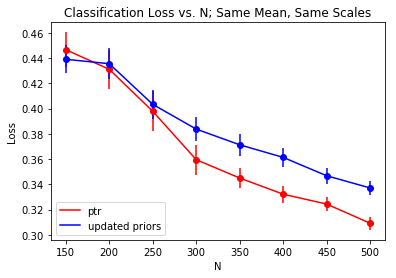

In [13]:
ptr_ss_means = np.array([np.mean(i) for i in ptr_test_ss])
up_ss_means = np.array([np.mean(i) for i in up_test_ss])

ptr_ss_std = np.array([np.std(i, ddof = 1) for i in ptr_test_ss])
up_ss_std = np.array([np.std(i, ddof = 1) for i in up_test_ss])

fig, ax = plt.subplots(1,1)

ax.plot(n, 1 - ptr_ss_means, label = 'ptr', c = 'r')
ax.plot(n, 1 - up_ss_means, label = 'updated priors', c = 'b')
ax.errorbar(n, 1 - ptr_ss_means, yerr = 1.96*ptr_ss_std/np.sqrt(it), fmt='o', c = 'r')
ax.errorbar(n, 1 - up_ss_means, yerr = 1.96*up_ss_std/np.sqrt(it), fmt='o', c = 'b')
ax.set_title('Classification Loss vs. N; Same Mean, Same Scales')
ax.set_xlabel('N')
ax.set_ylabel('Loss')
ax.legend(loc = 'lower left')

plt.savefig('ss_DAS.png')